## Import

In [23]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [24]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [25]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

## Uncertain Space

In [26]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [27]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':100004.412,'n_pax':120.0,'area':109.205,'ar':14.528,'fuel_type':'kerosene','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



In [28]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [29]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 17:29:41: *** Start Sampling execution ***
    INFO - 17:29:41: Sampling
    INFO - 17:29:41:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:29:41:    MDO formulation: MDF
    INFO - 17:29:41: Running the algorithm OT_MONTE_CARLO:
    INFO - 17:29:43:    100%|██████████| 100/100 [00:01<00:00, 59.80 it/sec]
    INFO - 17:29:43: *** End Sampling execution (time: 0:00:01.704933) ***


In [30]:
surrogate_discipline = SurrogateDiscipline("PolynomialRegressor", training_dataset)

In [31]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([0.99999999]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [32]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.99999999]),
 'length': array([nan]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [33]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([1.08187891e-06]),
 'length': array([0.]),
 'mtom': array([0.00109114]),
 'span': array([0.]),
 'tofl': array([0.00011868]),
 'vapp': array([5.94593502e-07]),
 'vz': array([1.91188342e-06])}

In [34]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([1.30485427e-06]),
 'length': array([0.]),
 'mtom': array([0.00147529]),
 'span': array([0.]),
 'tofl': array([0.00016867]),
 'vapp': array([7.39788745e-07]),
 'vz': array([2.42858379e-06])}

In [35]:
from matplotlib import pyplot as plt

from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [36]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00788825]),
 'cef': array([1.00629333]),
 'fm': array([0.50918795]),
 'length': array([32.]),
 'mtom': array([63512.65186885]),
 'sef': array([1.00791544]),
 'span': array([39.83127214]),
 'tofl': array([1921.40004914]),
 'vapp': array([66.66833433]),
 'vz': array([4.72191589])}

In [37]:
variance = statistics.compute_variance()
variance

{'aef': array([7.37077678e-05]),
 'cef': array([8.44338002e-05]),
 'fm': array([0.00017232]),
 'length': array([0.]),
 'mtom': array([85529.99534381]),
 'sef': array([7.1277677e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([282.65996246]),
 'vapp': array([0.02991358]),
 'vz': array([0.00868639])}

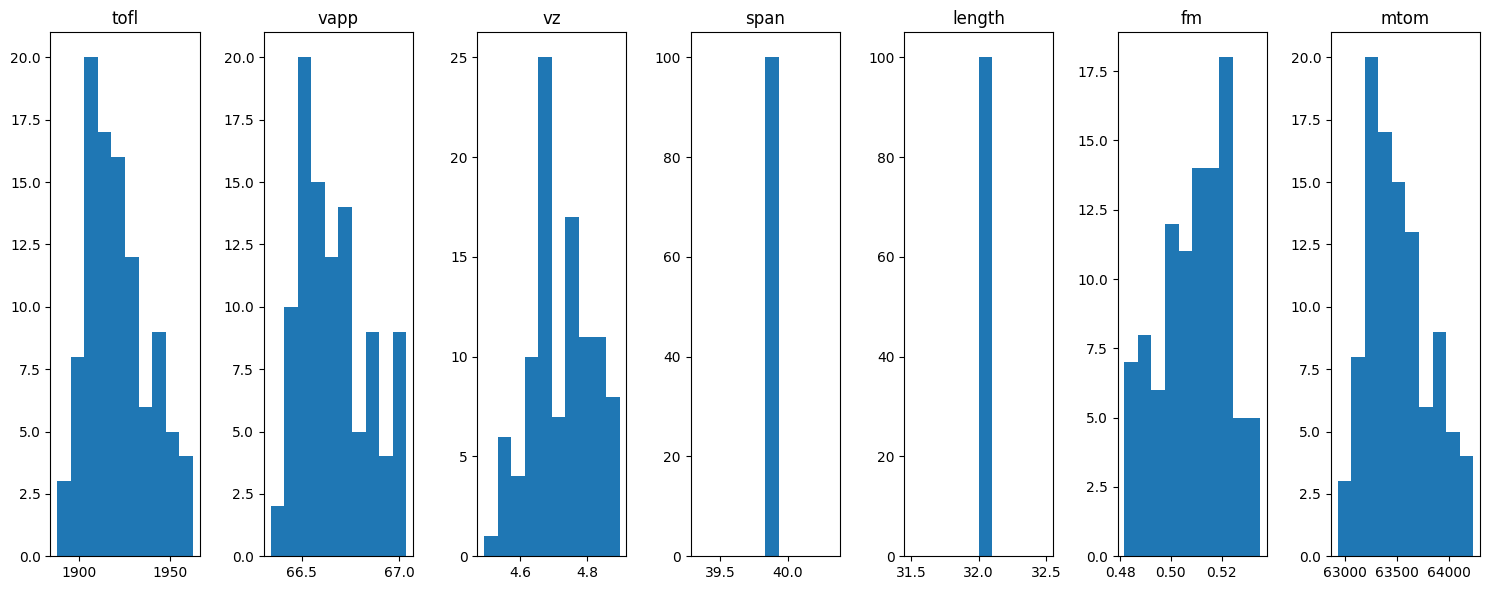

In [38]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [39]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [40]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 100)

 WARNING - 17:29:46: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:29:46: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 17:29:46: SobolAnalysisSamplingPhase
    INFO - 17:29:46:    Disciplines: PolyReg_Sampling
    INFO - 17:29:46:    MDO formulation: MDF
    INFO - 17:29:46: Running the algorithm OT_SOBOL_INDICES:
    INFO - 17:29:47:    100%|██████████| 96/96 [00:01<00:00, 70.56 it/sec]
    INFO - 17:29:47: *** End SobolAnalysisSamplingPhase execution (time: 0:00:01.377150) ***


GROUP        inputs                       outputs                       \
VARIABLE        aef       cef       sef        fm length          mtom   
COMPONENT         0         0         0         0      0             0   
0          1.011287  1.018858  1.018127  0.489522   32.0  64006.126525   
1          0.996470  0.998531  0.994315  0.527918   32.0  62915.224339   
2          1.012159  1.000496  1.024286  0.514163   32.0  64020.164223   
3          0.999643  0.997105  0.997688  0.527692   32.0  63029.568697   
4          0.999603  1.028623  0.996241  0.484408   32.0  63316.015949   
..              ...       ...       ...       ...    ...           ...   
91         0.995934  0.999781  0.997909  0.526530   32.0  63045.664510   
92         1.016577  1.002006  1.006415  0.509012   32.0  63463.021752   
93         1.005482  0.997079  0.994671  0.523617   32.0  62959.546734   
94         1.021060  1.007666  1.003858  0.498128   32.0  63462.090743   
95         1.011845  1.020575  1.001509  0.486829   32.0  63472.619164   

GROUP                                                   
VARIABLE        span         tofl       vapp        vz  
COMPONENT          0            0          0         0  
0          39.831272  1949.811880  66.877564  4.580520  
1          39.831272  1887.212322  66.389170  4.935207  
2          39.831272  1950.624560  67.003307  4.572269  
3          39.831272  1893.723301  66.458586  4.888580  
4          39.831272  1910.085733  66.428809  4.816546  
..               ...          ...        ...       ...  
91         39.831272  1894.640734  66.463115  4.905081  
92         39.831272  1918.512205  66.637787  4.686009  
93         39.831272  1889.734655  66.396516  4.874015  
94         39.831272  1918.458777  66.585328  4.661623  
95         39.831272  1919.063053  66.537094  4.709651  

[96 rows x 10 columns]

In [41]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'aef': array([0.16523875]), 'cef': array([0.29567937]), 'sef': array([0.22820366])}], 'vapp': [{'aef': array([0.10538857]), 'cef': array([0.10538853]), 'sef': array([0.28514899])}], 'vz': [{'aef': array([0.44862131]), 'cef': array([0.40949942]), 'sef': array([0.11003383])}], 'fm': [{'aef': array([-0.23279666]), 'cef': array([0.97321916]), 'sef': array([-0.24966471])}], 'mtom': [{'aef': array([0.16559059]), 'cef': array([0.29690062]), 'sef': array([0.2295905])}]}, second={'tofl': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.3527343]]), 'sef': array([[-0.30840461]])}, 'cef': {'aef': array([[-0.3527343]]), 'cef': array([[0.]]), 'sef': array([[-0.39186103]])}, 'sef': {'aef': array([[-0.30840461]]), 'cef': array([[-0.39186103]]), 'sef': array([[0.]])}}], 'vapp': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.20250901]]), 'sef': array([[-0.20250931]])}, 'cef': {'aef': array([[-0.20250901]]), 'cef': array([[0.]]), 'sef': array([[-0.202

In [42]:
import pprint

In [43]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([-0.23279666]),
         'cef': array([0.97321916]),
         'sef': array([-0.24966471])}],
 'mtom': [{'aef': array([0.16559059]),
           'cef': array([0.29690062]),
           'sef': array([0.2295905])}],
 'tofl': [{'aef': array([0.16523875]),
           'cef': array([0.29567937]),
           'sef': array([0.22820366])}],
 'vapp': [{'aef': array([0.10538857]),
           'cef': array([0.10538853]),
           'sef': array([0.28514899])}],
 'vz': [{'aef': array([0.44862131]),
         'cef': array([0.40949942]),
         'sef': array([0.11003383])}]}
{'fm': [{'aef': array([0.07662089]),
         'cef': array([1.17831896]),
         'sef': array([-8.09040802e-05])}],
 'mtom': [{'aef': array([-0.03054363]),
           'cef': array([0.06110316]),
           'sef': array([0.78413236])}],
 'tofl': [{'aef': array([-0.03153673]),
           'cef': array([0.06072655]),
           'sef': array([0.78534523])}],
 'vapp': [{'aef': array([-0.00056142]),
           'cef': 

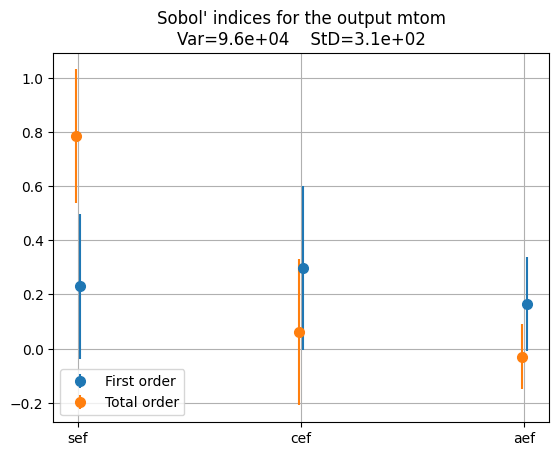

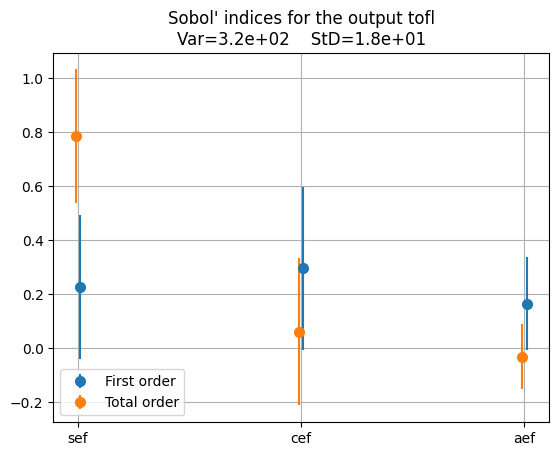

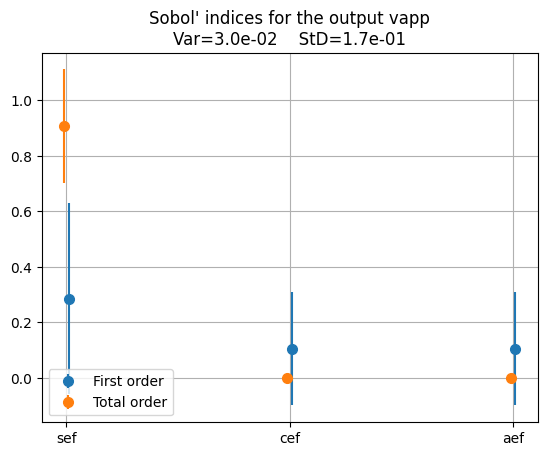

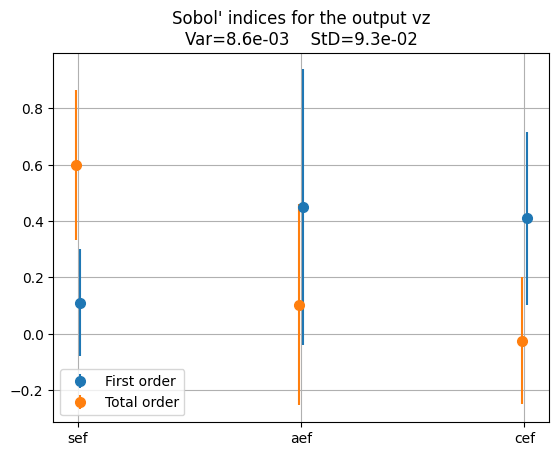

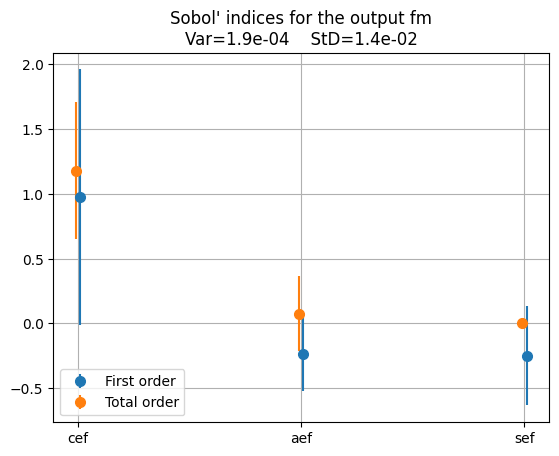

In [44]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))



